# Super Resolution of flying objects using SRGAN

The objective of this model is to recover high resolution images from low resolution images of flying objects (birds, small/large quadcopters and drones). The model is based on SRGAN.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!nvidia-smi

Sat Oct 10 13:45:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 37.0MB/s 


## Import necessary packages

In [5]:
import shutil
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import random

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from math import log10

In [6]:
cd '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S7_NeuralTransfer_SRGAN/SRGAN'

/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S7_NeuralTransfer_SRGAN/SRGAN


In [7]:
import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from loss import GeneratorLoss
from model import Generator, Discriminator

In [8]:
cd /content

/content


In [9]:
#gdrive path
gdrive_path = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/'

# Configuration
CROP_SIZE = 88
UPSCALE_FACTOR = 2
NUM_EPOCHS = 10

## Data download and prep

In [10]:
if not os.path.exists("data"):
    shutil.copy(os.path.join(gdrive_path,"S2_MobileNetv2_Flying", "drone_dataset.zip"), os.getcwd())
    os.mkdir("data")
    !unzip -q drone_dataset.zip -d data/

In [11]:
# Dataloader requires all class images to be present in single folder. Since image names are numbers, there are few images with the same
# name present in different folders. Hence, appending the first character of the folder name to the image name.
for folder_type in os.listdir('data/drone_dataset'):  
    for class_folder in os.listdir(os.path.join('data/drone_dataset', folder_type)):
        ca = class_folder[0]
        for image_file in os.listdir(os.path.join('data/drone_dataset', folder_type, class_folder)):
            os.rename(os.path.join('data/drone_dataset',folder_type,class_folder,image_file), os.path.join('data/drone_dataset',folder_type,ca+"_"+image_file))
        os.rmdir(os.path.join('data/drone_dataset',folder_type,class_folder))

In [12]:
# Since val folder contains ~5k data and this volume causes memory issue, validation is now done on 10 images.
# Renaming original val folder as val_full and copying random 10 images to the new val folder. 
os.rename('data/drone_dataset/val', 'data/drone_dataset/val_full')
os.mkdir('data/drone_dataset/val')
val_files = glob.glob('data/drone_dataset/val_full/*')
for img in random.sample(val_files, 10):
    shutil.copy(img, 'data/drone_dataset/val')

In [13]:
ls './data/drone_dataset/train' | wc -l

12958


In [14]:
ls './data/drone_dataset/val' | wc -l

10


## Sample training image and Model Summary

In [21]:
train_set = TrainDatasetFromFolder(dataset_directory='data/drone_dataset/train', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(dataset_directory='data/drone_dataset/val', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, pin_memory=True)

In [14]:
dataiter = iter(train_loader)
l_image, h_image = next(dataiter)

### Sample training images

Training images consists of low (resized by up_scale factor) and high resolution images (random cropped).

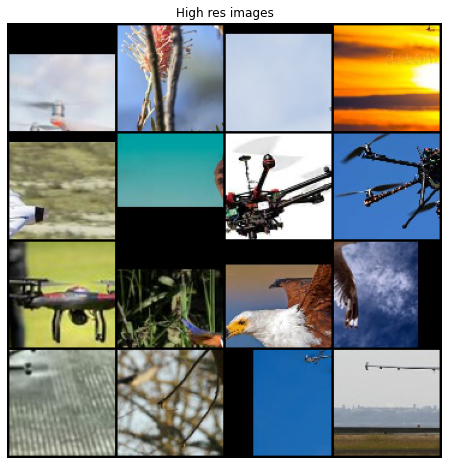

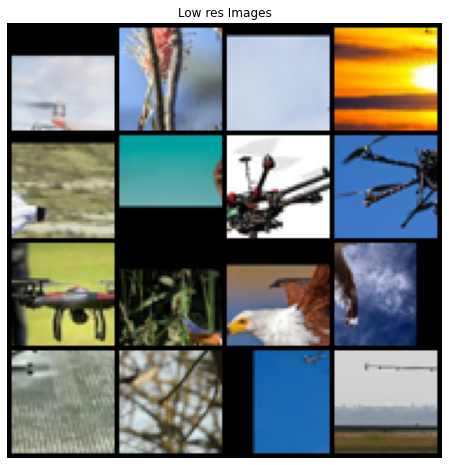

In [15]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("High res images")
plt.imshow(np.transpose(utils.make_grid(h_image[:16], nrow=4), (1,2,0)))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Low res Images")
plt.imshow(np.transpose(utils.make_grid(l_image[:16], nrow=4), (1,2,0)))

### Generator, Discriminator model instances

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: ", device)
netG = Generator(UPSCALE_FACTOR).to(device)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator().to(device)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

Available device:  cuda:0
# generator parameters: 586506
# discriminator parameters: 5215425


In [16]:
# Generator model Summary
summary(netG, input_size=(3, 88, 88))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 88, 88]          15,616
             PReLU-2           [-1, 64, 88, 88]               1
            Conv2d-3           [-1, 64, 88, 88]          36,928
       BatchNorm2d-4           [-1, 64, 88, 88]             128
             PReLU-5           [-1, 64, 88, 88]               1
            Conv2d-6           [-1, 64, 88, 88]          36,928
       BatchNorm2d-7           [-1, 64, 88, 88]             128
     ResidualBlock-8           [-1, 64, 88, 88]               0
            Conv2d-9           [-1, 64, 88, 88]          36,928
      BatchNorm2d-10           [-1, 64, 88, 88]             128
            PReLU-11           [-1, 64, 88, 88]               1
           Conv2d-12           [-1, 64, 88, 88]          36,928
      BatchNorm2d-13           [-1, 64, 88, 88]             128
    ResidualBlock-14           [-1, 64,

In [17]:
# Discriminator model summary
summary(netD, input_size=(3, 88, 88))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 88, 88]           1,792
         LeakyReLU-2           [-1, 64, 88, 88]               0
            Conv2d-3           [-1, 64, 44, 44]          36,928
       BatchNorm2d-4           [-1, 64, 44, 44]             128
         LeakyReLU-5           [-1, 64, 44, 44]               0
            Conv2d-6          [-1, 128, 44, 44]          73,856
       BatchNorm2d-7          [-1, 128, 44, 44]             256
         LeakyReLU-8          [-1, 128, 44, 44]               0
ConvolutionalBlock-9          [-1, 128, 44, 44]               0
           Conv2d-10          [-1, 128, 22, 22]         147,584
      BatchNorm2d-11          [-1, 128, 22, 22]             256
        LeakyReLU-12          [-1, 128, 22, 22]               0
           Conv2d-13          [-1, 256, 22, 22]         295,168
      BatchNorm2d-14          [-1, 256,

## Model Training

### Loss Function

In [18]:
generator_criterion = GeneratorLoss().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [19]:
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [22]:
# Training part
for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes':0, 'd_loss':0, 'g_loss':0, 'd_score':0, 'g_score':0}

    netG = netG.train()
    netD = netD.train()

    for z, real_img in train_bar:
        g_update_first = True
        batch_size = real_img.size(0)
        running_results['batch_sizes'] += batch_size
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        z = z.to(device)
        real_img = real_img.to(device)
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ############################
        netG.zero_grad()
        # Calculate generator and discriminator model again to prevent in-place modification
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

    train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))
        
    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        val_results = {'batch_sizes': 0, 'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0}
        val_images = []

        for val_lr, val_hr_restored, val_hr in val_bar:
            batch_size = val_lr.size(0)
            val_results['batch_sizes'] += batch_size
            val_lr = val_lr.to(device)
            val_hr = val_hr.to(device)
            sr = netG(val_lr)
            batch_mse = ((sr - val_hr)**2).data.mean()
            val_results['mse'] += batch_mse * batch_size
            ######
            # it should be pytorch_ssim.ssim (from .py file)
            ######
            batch_ssim = pytorch_ssim.ssim(sr, val_hr).item()
            val_results['ssims'] += batch_ssim * batch_size
            val_results['psnr'] = 10 * log10((val_hr.max()**2) / (val_results['mse'] / val_results['batch_sizes']))
            val_results['ssim'] = val_results['ssims'] / val_results['batch_sizes']
            val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                    val_results['psnr'], val_results['ssim']))
            val_images.extend(
                [display_transform()(val_hr_restored.squeeze(0)), display_transform()(val_hr.data.cpu().squeeze(0)),
                    display_transform()(sr.data.cpu().squeeze(0))])
            
        val_images = torch.stack(val_images)
        val_images = torch.chunk(val_images, val_images.size(0) // 15)
        val_save_bar = tqdm(val_images, desc='[saving training results]')
        index = 1
        for image in val_save_bar:
            image = utils.make_grid(image, nrow=3, padding=5)
            utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
            index += 1
            
    # save model parameters
    # torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    # torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    # save loss\scores\psnr\ssim
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(val_results['psnr'])
    results['ssim'].append(val_results['ssim'])

    # if epoch % 10 == 0 and epoch != 0:
    #     out_path = 'statistics/'
    #     data_frame = pd.DataFrame(
    #         data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
    #                 'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
    #         index=range(1, epoch + 1))
    #     data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')


100%|██████████| 203/203 [01:46<00:00,  1.91it/s]
[converting LR images to SR images] PSNR: 22.9631 dB SSIM: 0.8092: 100%|██████████| 10/10 [00:00<00:00, 26.49it/s]
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
[converting LR images to SR images] PSNR: 27.4297 dB SSIM: 0.8963: 100%|██████████| 10/10 [00:00<00:00, 28.08it/s]
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
[converting LR images to SR images] PSNR: 27.9836 dB SSIM: 0.8992: 100%|██████████| 10/10 [00:00<00:00, 27.94it/s]
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
[converting LR images to SR images] PSNR: 27.9126 dB SSIM: 0.9100: 100%|██████████| 10/10 [00:00<00:00, 27.97it/s]
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
[converting LR images to SR images] PSNR: 28.6301 dB SSIM: 0.9210: 100%|██████████| 10/10 [00:00<00:00, 27.79it/s]
100%|██████████| 203/203 [01:45<00:00,  1.92it/s]
[converting LR images to SR images] PSNR: 29.1072 dB SSIM: 0.9187: 100%|██████████| 10/10 [00:00<00:00, 28.12it/s]
100%|█████

In [23]:
results

{'d_loss': [0.8864422447888604,
  1.0026411475876191,
  1.0022701957487439,
  1.0014566221084835,
  1.0020290760921096,
  1.0022832331493288,
  1.0014328151449117,
  1.0009686085412046,
  0.9988376064458035,
  1.0012911720801363],
 'd_score': [0.6173008433148566,
  0.6436010176687628,
  0.6825960154959515,
  0.6290076662037251,
  0.43029298270295147,
  0.47039231944551513,
  0.43682126658329684,
  0.4633212997913729,
  0.43848414103877015,
  0.449327624999625],
 'g_loss': [0.012856043685618044,
  0.0057923116427685975,
  0.004245088002893876,
  0.00378424016510696,
  0.003734756759473536,
  0.003580629690831289,
  0.003419883879107731,
  0.003265897977240769,
  0.0031723830081191277,
  0.0031890755334990062],
 'g_score': [0.4906376004483546,
  0.6455632292722033,
  0.6826308481136504,
  0.6290484890652247,
  0.42947206463705595,
  0.4704424724118506,
  0.4378859539572187,
  0.46251979619287603,
  0.4368422202332407,
  0.4508233756024743],
 'psnr': [22.963145307593624,
  27.429683736752

## Results

### Generator Discriminator Loss

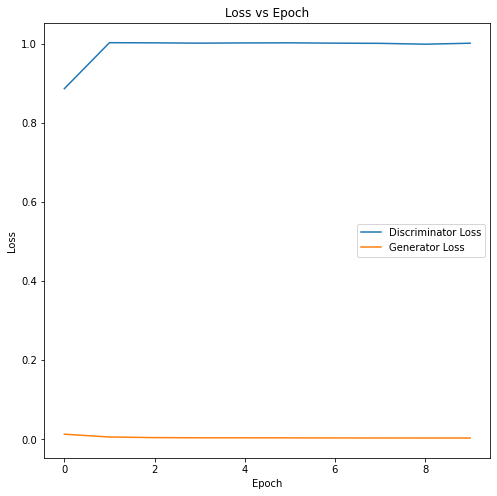

In [24]:
plt.figure(figsize=(8,8))
plt.title("Loss vs Epoch")
plt.plot(results['d_loss'], label = "Discriminator Loss")
plt.plot(results['g_loss'], label = "Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")

### PSNR and SSIM Trend

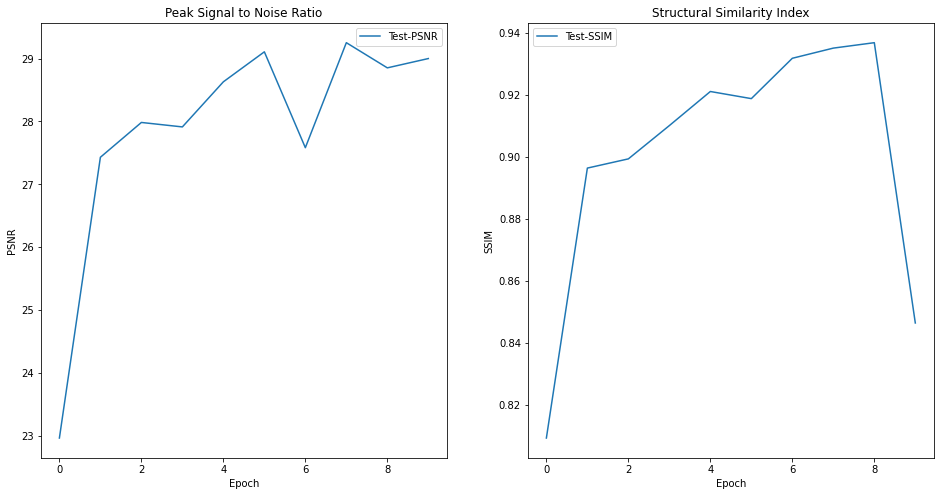

In [25]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].set_title("Peak Signal to Noise Ratio")
axs[0].plot(results['psnr'], label = "Test-PSNR")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("PSNR")
axs[0].legend(loc="best")

axs[1].set_title("Structural Similarity Index")
axs[1].plot(results['ssim'], label = "Test-SSIM")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("SSIM")
axs[1].legend(loc="best")

## Result and Model export

In [26]:
shutil.move('training_results/SRF_2', os.path.join(gdrive_path, "S7_NeuralTransfer_SRGAN/SRGAN/results"))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S7_NeuralTransfer_SRGAN/SRGAN/results/SRF_2'

In [27]:
netG = netG.to(torch.device("cpu"))
netG.eval()
traced_model = torch.jit.trace(netG, torch.randn(1, 3, 88, 88))
traced_model.save("srgan_flyingobjects.pt")

In [28]:
shutil.move("srgan_flyingobjects.pt", os.path.join(gdrive_path, "S7_NeuralTransfer_SRGAN/SRGAN/saved_models"))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S7_NeuralTransfer_SRGAN/SRGAN/saved_models/srgan_flyingobjects.pt'

## Model inference for deployment

For the image uploaded, recreate Low resolution image 

In [1]:
import os
import shutil

In [2]:
#gdrive path
gdrive_path = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/'

# Configuration
CROP_SIZE = 88
UPSCALE_FACTOR = 2


In [3]:
shutil.copy(os.path.join(gdrive_path, gdrive_path, "S7_NeuralTransfer_SRGAN/SRGAN/saved_models/srgan_flyingobjects.pt"), os.getcwd())

'/content/srgan_flyingobjects.pt'

### Single image inferencing

In [4]:
# Necessary packages
import os
from PIL import Image
import torch
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [5]:
netG = torch.jit.load("srgan_flyingobjects.pt")

In [6]:
input_image = Image.open('flying_bird.jpg')

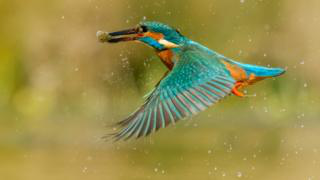

In [7]:
input_image

In [8]:
# Provide valid crop size. Returns multiple of upscale_factor
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

In [9]:
# Provides set of Low resolution images, High resolution images restored by Bicubic interpolation and the actual input HR image (centercropped.)
def image_transform_LR_HR_Restored(HR_image, crop_size, upscale_factor):
    LR_scale = Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC)
    HR_scale = Resize(crop_size, interpolation=Image.BICUBIC)

    HR_image = CenterCrop(crop_size)(HR_image)
    LR_image = LR_scale(HR_image)
    HR_restored_image = HR_scale(LR_image)
    return ToTensor()(LR_image), ToTensor()(HR_restored_image), ToTensor()(HR_image)


In [10]:
input_image = Image.open('flying_bird.jpg')
w, h = input_image.size
crop_size = calculate_valid_crop_size(min(w, h), UPSCALE_FACTOR)
val_lr, val_hr_restored, val_hr = image_transform_LR_HR_Restored(input_image, crop_size, UPSCALE_FACTOR)

In [11]:
# Verification
print(w, h)
print(crop_size)
print(val_lr.shape)
print(val_hr_restored.shape)
print(val_hr.shape)
print(val_lr.unsqueeze(0).shape)

320 180
180
torch.Size([3, 90, 90])
torch.Size([3, 180, 180])
torch.Size([3, 180, 180])
torch.Size([1, 3, 90, 90])


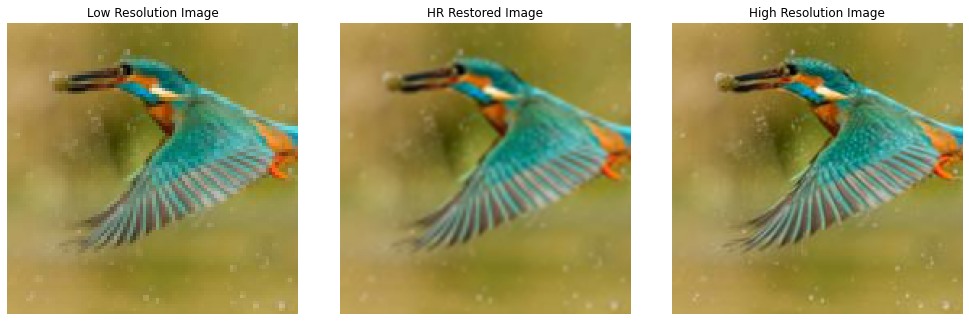

In [12]:
# Not required for handler.py
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize = (14,14))
fig.tight_layout()
axs[0].axis("off")
axs[0].set_title(f'Low Resolution Image')
axs[0].imshow(val_lr.permute(1,2,0))

axs[1].axis("off")
axs[1].set_title(f'HR Restored Image')
axs[1].imshow(val_hr_restored.permute(1,2,0))

axs[2].axis("off")
axs[2].set_title(f'High Resolution Image')
axs[2].imshow(val_hr.permute(1,2,0))

In [13]:
# Image inference
with torch.no_grad():
    val_lr = val_lr.to(torch.device("cpu")).unsqueeze(0)
    sr = netG(val_lr)

In [14]:
print(sr.shape)

torch.Size([1, 3, 180, 180])


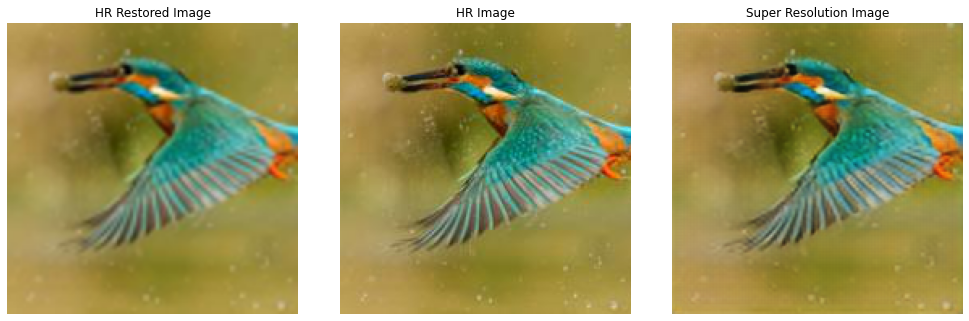

In [15]:
# Not required for handler.py
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize = (14,14))
fig.tight_layout()
axs[0].axis("off")
axs[0].set_title(f'HR Restored Image')
axs[0].imshow(val_hr_restored.permute(1,2,0))

axs[1].axis("off")
axs[1].set_title(f'HR Image')
axs[1].imshow(val_hr.permute(1,2,0))

axs[2].axis("off")
axs[2].set_title(f'Super Resolution Image')
axs[2].imshow(sr.squeeze().permute(1,2,0))

In [20]:
print(type(sr))

<class 'torch.Tensor'>


In [19]:
print(sr.shape)

torch.Size([1, 3, 180, 180])
